#  Reinforcement Learning 

## Problem Statement 
Apply a suitable RL architecture to the problem. Land the LunarLander successfully on the landing pad.

## About LunarLander

### What is LunarLander
LunarLander is a reinforcement learning environment developed by OpenAI, it is a simulation of a lunar landing mission where an agent must navigate a lunar module to land safely on the moon. The objective of the agent is to maximize its reward by landing the module safely while conserving fuel. It is often used as a benchmark problem for testing and evaluating reinforcement learning algorithms.

This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two environment versions: discrete or continuous. The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt.

### Action Space
There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

### Observation Space
The state is an 8-dimensional vector: the coordinates of the lander in x & y, its linear velocities in x & y, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

### Rewards
Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

### Starting State

The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

### Episode Termination
The episode finishes if:

- the lander crashes (the lander body gets in contact with the moon);
- the lander gets outside of the viewport (x coordinate is greater than 1);
- the lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body:

## Our Goal

Our goal is to "Solve" the game, in order to do that we are aiming to achieve a average reward of above 200

# About DQN

To understand DQN we must first understand Q learning. Q learning is a classic value based reinforcement learning model which aims to train the model to learn the best value function. This allows the algorithm to get better at estimating the value of an action in a particular state. Value here is defined as the probability of receiving a future award. Or to put it more succinctly it allows the algorithm to learn which action will get it closer to solving the environment. To achieve this q learning stores a q table. A q table is essentially a set of all possible states and actions along with the expected rewards. As the model learns and experiments more the expected rewards are further refined using the bellman optimlity equation defined below.

![Bellman equation](./pic/bellman.png "bellman")

This equation says that at any time t, for any state-action pair (s,a), the expected return from starting state s, taking action a, and with the optimal policy will be equal to the expected reward of selecting action a in state s in addition to maximum "expected discounted return" that is achievable for subsequent actions. Essentially this equation ensures that any action taken at the current state is linked to the next state's expected reward. This allows the model to optimize both the best possible immediate action while taking into account the future expected rewards as well. The bellman optimality equation is a recursive equation wherein all the estimated rewards for the state action pairs in a particular episode are updated at once once the episode ends.

Although Q-learning is able to eventually find the optimal actions and solve the environment due to the Q table, extreme amounts of memory is required for training. DQN is an optimization for this problem where instead of having a q table to store state action pairs and their rewards a dense network is used to approximate the reward instead.This allows for lesser memory to be required compared to the traditional Q table.

# Imports

In [1]:
import gym
import numpy as np
import pandas as pd
from collections import deque
import random

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.activations import relu, linear
from keras.optimizers import Adam
from keras.losses import mean_squared_error
from keras.models import load_model


import pickle
from matplotlib import pyplot as plt   

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[]


# Model

In [3]:
class DQN:
    def __init__(self, env, lr, gamma, epsilon, epsilon_decay):
        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        self.counter = 0

        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.rewards_list = []

        self.replay_memory_buffer = deque(maxlen=500000)
        self.batch_size = 64
        self.epsilon_min = 0.01
        self.num_action_space = self.action_space.n
        self.num_observation_space = env.observation_space.shape[0]
        self.model = self.initialize_model()

    def initialize_model(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.num_observation_space, activation=relu))
        model.add(Dense(256, activation=relu))
        model.add(Dense(self.num_action_space, activation=linear))

        # Compile the model
        model.compile(loss=mean_squared_error,optimizer=Adam(lr=self.lr))
        print(model.summary())
        return model

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.num_action_space)

        predicted_actions = self.model.predict(state, verbose = 0)
        return np.argmax(predicted_actions[0])

    def add_to_replay_memory(self, state, action, reward, next_state, done):
        self.replay_memory_buffer.append((state, action, reward, next_state, done))

    def learn_and_update_weights_by_reply(self):

        # replay_memory_buffer size check
        if len(self.replay_memory_buffer) < self.batch_size or self.counter != 0:
            return

        # Early Stopping
        if np.mean(self.rewards_list[-10:]) > 180:
            return

        random_sample = self.get_random_sample_from_replay_mem()
        states, actions, rewards, next_states, done_list = self.get_attribues_from_sample(random_sample)
        targets = rewards + self.gamma * (np.amax(self.model.predict_on_batch(next_states), axis=1)) * (1 - done_list)
        target_vec = self.model.predict_on_batch(states)
        indexes = np.array([i for i in range(self.batch_size)])
        target_vec[[indexes], [actions]] = targets

        self.model.fit(states, target_vec, epochs=1, verbose=0)

    def get_attribues_from_sample(self, random_sample):
        states = np.array([i[0] for i in random_sample])
        actions = np.array([i[1] for i in random_sample])
        rewards = np.array([i[2] for i in random_sample])
        next_states = np.array([i[3] for i in random_sample])
        done_list = np.array([i[4] for i in random_sample])
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        return np.squeeze(states), actions, rewards, next_states, done_list

    def get_random_sample_from_replay_mem(self):
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample

    def train(self, num_episodes=2000, can_stop=True):
        for episode in range(num_episodes):
            state = self.env.reset()
            reward_for_episode = 0
            num_steps = 1000
            state = np.reshape(state, [1, self.num_observation_space])
            for step in range(num_steps):
                self.env.render()
                received_action = self.get_action(state)
                # print("received_action:", received_action)
                next_state, reward, done, info = env.step(received_action)
                next_state = np.reshape(next_state, [1, self.num_observation_space])
                # Store the experience in replay memory
                self.add_to_replay_memory(state, received_action, reward, next_state, done)
                # add up rewards
                reward_for_episode += reward
                state = next_state
                self.update_counter()
                self.learn_and_update_weights_by_reply()

                if done:
                    break
            self.rewards_list.append(reward_for_episode)

            # Decay the epsilon after each experience completion
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            # Check for breaking condition
            last_rewards_mean = np.mean(self.rewards_list[-100:])
            if last_rewards_mean > 200 and can_stop:
                print("DQN Training Complete...")
                break
            print(episode, "\t: Episode || Reward: ",reward_for_episode, "\t|| Average Reward: ",last_rewards_mean, "\t epsilon: ", self.epsilon )

    def update_counter(self):
        self.counter += 1
        step_size = 5
        self.counter = self.counter % step_size

    def save(self, name):
        self.model.save(name)

In [4]:
def plot_df(df, chart_name, title, x_axis_label, y_axis_label):
    plt.rcParams.update({'font.size': 17})
    df['rolling_mean'] = df[df.columns[0]].rolling(100).mean()
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    # plot = df.plot(linewidth=1.5, figsize=(15, 8), title=title)
    plot = df.plot(linewidth=1.5, figsize=(15, 8))
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    # plt.ylim((-400, 300))
    fig = plot.get_figure()
    plt.legend().set_visible(False)
    fig.savefig(chart_name)


def plot_df2(df, chart_name, title, x_axis_label, y_axis_label):
    df['mean'] = df[df.columns[0]].mean()
    plt.rcParams.update({'font.size': 17})
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    # plot = df.plot(linewidth=1.5, figsize=(15, 8), title=title)
    plot = df.plot(linewidth=1.5, figsize=(15, 8))
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.ylim((0, 300))
    plt.xlim((0, 100))
    plt.legend().set_visible(False)
    fig = plot.get_figure()
    fig.savefig(chart_name)


def plot_experiments(df, chart_name, title, x_axis_label, y_axis_label, y_limit):
    plt.rcParams.update({'font.size': 17})
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    plot = df.plot(linewidth=1, figsize=(15, 8), title=title)
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.ylim(y_limit)
    fig = plot.get_figure()
    fig.savefig(chart_name)

In [5]:
def test_already_trained_model(trained_model):
    rewards_list = []
    num_test_episode = 100
    env = gym.make("LunarLander-v2")
    print("Starting Testing of the trained model...")

    step_count = 1000

    for test_episode in range(num_test_episode):
        current_state = env.reset()
        num_observation_space = env.observation_space.shape[0]
        current_state = np.reshape(current_state, [1, num_observation_space])
        reward_for_episode = 0
        for step in range(step_count):
            env.render()
            selected_action = np.argmax(trained_model.predict(current_state)[0])
            new_state, reward, done, info = env.step(selected_action)
            new_state = np.reshape(new_state, [1, num_observation_space])
            current_state = new_state
            reward_for_episode += reward
            if done:
                break
        rewards_list.append(reward_for_episode)
        print(test_episode, "\t: Episode || Reward: ", reward_for_episode)

    return rewards_list

# Defining hyperparameters and training

In [8]:
env = gym.make('LunarLander-v2')

# set seeds
env.seed(21)
np.random.seed(21)

# setting up params
lr = 0.001
epsilon = 1.0
epsilon_decay = 0.996
gamma = 0.99
training_episodes = 2000
print('St')
model = DQN(env, lr, gamma, epsilon, epsilon_decay)
# Save Everything
save_dir = "saved_models"

St
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               2304      
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 69,124
Trainable params: 69,124
Non-trainable params: 0
_________________________________________________________________
None


St
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 69,124
Trainable params: 69,124
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\p2119487\.conda\envs\rl_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\p2119487\.conda\envs\rl_env\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\p2119487\.conda\envs\rl_env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0 	: Episode || Reward:  -248.72600940346106 	|| Average Reward:  -248.72600940346106 	 epsilon:  0.996
1 	: Episode || Reward:  -147.5552303626243 	|| Average Reward:  -198.1406198830427 	 epsilon:  0.992016
2 	: Episode || Reward:  -136.88490008043743 	|| Average Reward:  -177.7220466155076 	 epsilon:  0.988047936
3 	: Episode || Reward:  -99.59339061581068 	|| Average Reward:  -158.18988261558337 	 epsilon:  0.984095744256
4 	: Episode || Reward:  -89.98276200165843 	|| Average Reward:  -144.54845849279837 	 epsilon:  0.980159361278976
5 	: Episode || Reward:  -79.3665997376441 	|| Average Reward:  -133.68481536693935 	 epsilon:  0.97623872383386
6 	: Episode || Reward:  -41.62231665260538 	|| Average Reward:  -120.53302983632021 	 epsilon:  0.9723337689385245
7 	: Episode || Reward:  -344.65512228592206 	|| Average Reward:  -148.54829139252044 	 epsilon:  0.9684444338627705
8 	: Episode || Reward:  -121.8146526809998 	|| Average Reward:  -145.57788709124037 	 epsilon:  0.9645706561

71 	: Episode || Reward:  -229.75186198218387 	|| Average Reward:  -123.9620819124753 	 epsilon:  0.7493286994807209
72 	: Episode || Reward:  -55.82004548967209 	|| Average Reward:  -123.02862935873827 	 epsilon:  0.746331384682798
73 	: Episode || Reward:  -113.67620299801445 	|| Average Reward:  -122.90224521872848 	 epsilon:  0.7433460591440668
74 	: Episode || Reward:  -60.38455309977523 	|| Average Reward:  -122.06867599047577 	 epsilon:  0.7403726749074906
75 	: Episode || Reward:  -113.19891975545877 	|| Average Reward:  -121.95196867159397 	 epsilon:  0.7374111842078607
76 	: Episode || Reward:  -84.21217529112236 	|| Average Reward:  -121.46184148483461 	 epsilon:  0.7344615394710292
77 	: Episode || Reward:  18.793941069351717 	|| Average Reward:  -119.6636904264476 	 epsilon:  0.731523693313145
78 	: Episode || Reward:  -133.8460863044047 	|| Average Reward:  -119.84321442490274 	 epsilon:  0.7285975985398925
79 	: Episode || Reward:  -39.56035453739756 	|| Average Reward: 

141 	: Episode || Reward:  -22.77248969153854 	|| Average Reward:  -78.17418370987359 	 epsilon:  0.5660125440168996
142 	: Episode || Reward:  -57.662329832095764 	|| Average Reward:  -77.24046671792603 	 epsilon:  0.563748493840832
143 	: Episode || Reward:  -78.94471007050448 	|| Average Reward:  -77.28567996564438 	 epsilon:  0.5614934998654687
144 	: Episode || Reward:  -60.549591426061866 	|| Average Reward:  -76.48938894341686 	 epsilon:  0.5592475258660068
145 	: Episode || Reward:  -234.8079992091537 	|| Average Reward:  -78.2350112026194 	 epsilon:  0.5570105357625428
146 	: Episode || Reward:  -87.47480536915899 	|| Average Reward:  -77.88217662309809 	 epsilon:  0.5547824936194926
147 	: Episode || Reward:  -19.34506513084456 	|| Average Reward:  -76.90938633934142 	 epsilon:  0.5525633636450147
148 	: Episode || Reward:  -74.38084003071964 	|| Average Reward:  -76.72219063126641 	 epsilon:  0.5503531101904346
149 	: Episode || Reward:  -111.60615070940658 	|| Average Rewar

211 	: Episode || Reward:  9.783764287445976 	|| Average Reward:  -86.63012526407502 	 epsilon:  0.42754294638187057
212 	: Episode || Reward:  -220.97995524337958 	|| Average Reward:  -87.40162455996673 	 epsilon:  0.4258327745963431
213 	: Episode || Reward:  -48.09003409781518 	|| Average Reward:  -86.74030536131613 	 epsilon:  0.4241294434979577
214 	: Episode || Reward:  -73.48181223896091 	|| Average Reward:  -85.3825518086665 	 epsilon:  0.4224329257239659
215 	: Episode || Reward:  -59.85175528260346 	|| Average Reward:  -84.22588629036325 	 epsilon:  0.42074319402107
216 	: Episode || Reward:  -172.81044282637868 	|| Average Reward:  -86.0493687446501 	 epsilon:  0.41906022124498576
217 	: Episode || Reward:  -36.67614751954912 	|| Average Reward:  -85.11863183353046 	 epsilon:  0.41738398036000585
218 	: Episode || Reward:  -82.02839052001664 	|| Average Reward:  -85.27716198558828 	 epsilon:  0.4157144444385658
219 	: Episode || Reward:  -260.86697916067584 	|| Average Rewar

281 	: Episode || Reward:  70.40687098507985 	|| Average Reward:  -65.59354975823959 	 epsilon:  0.32294862178078065
282 	: Episode || Reward:  39.30433909317318 	|| Average Reward:  -63.85783898715479 	 epsilon:  0.3216568272936575
283 	: Episode || Reward:  49.33757580588019 	|| Average Reward:  -61.01253724739295 	 epsilon:  0.3203701999844829
284 	: Episode || Reward:  10.89170892337972 	|| Average Reward:  -60.541802367671714 	 epsilon:  0.31908871918454496
285 	: Episode || Reward:  -206.35605094494878 	|| Average Reward:  -61.62606013122582 	 epsilon:  0.3178123643078068
286 	: Episode || Reward:  38.85822749019361 	|| Average Reward:  -60.68142705442551 	 epsilon:  0.31654111485057557
287 	: Episode || Reward:  -130.7893169915275 	|| Average Reward:  -60.75512718978309 	 epsilon:  0.31527495039117326
288 	: Episode || Reward:  -52.18021133873414 	|| Average Reward:  -58.89017298559569 	 epsilon:  0.31401385058960857
289 	: Episode || Reward:  64.19373363880959 	|| Average Rewar

351 	: Episode || Reward:  95.46881852328869 	|| Average Reward:  -17.613097250259486 	 epsilon:  0.24394230613022727
352 	: Episode || Reward:  -194.97899378152897 	|| Average Reward:  -19.218751752347803 	 epsilon:  0.24296653690570635
353 	: Episode || Reward:  82.68261102409929 	|| Average Reward:  -18.38050480658005 	 epsilon:  0.24199467075808354
354 	: Episode || Reward:  20.085247782820453 	|| Average Reward:  -18.120558166711447 	 epsilon:  0.2410266920750512
355 	: Episode || Reward:  -113.83344143709243 	|| Average Reward:  -18.551569289819607 	 epsilon:  0.240062585306751
356 	: Episode || Reward:  71.02303365451854 	|| Average Reward:  -17.517715688333286 	 epsilon:  0.239102334965524
357 	: Episode || Reward:  271.1378768373507 	|| Average Reward:  -15.301335093736641 	 epsilon:  0.2381459256256619
358 	: Episode || Reward:  130.55036940709851 	|| Average Reward:  -13.749414212636609 	 epsilon:  0.23719334192315925
359 	: Episode || Reward:  54.688875611843095 	|| Average

421 	: Episode || Reward:  91.23972004667552 	|| Average Reward:  35.205705624674025 	 epsilon:  0.18426413586161025
422 	: Episode || Reward:  274.1153959576968 	|| Average Reward:  37.8196336923072 	 epsilon:  0.1835270793181638
423 	: Episode || Reward:  6.085703214483569 	|| Average Reward:  38.347541647168455 	 epsilon:  0.18279297100089115
424 	: Episode || Reward:  36.48555872403164 	|| Average Reward:  38.06927206120512 	 epsilon:  0.18206179911688758
425 	: Episode || Reward:  101.13846976295167 	|| Average Reward:  38.6703434363039 	 epsilon:  0.18133355192042003
426 	: Episode || Reward:  -111.47819921244171 	|| Average Reward:  37.531756621817124 	 epsilon:  0.18060821771273836
427 	: Episode || Reward:  132.87037507003222 	|| Average Reward:  41.90599292188821 	 epsilon:  0.17988578484188741
428 	: Episode || Reward:  225.38673621313683 	|| Average Reward:  44.28973226921156 	 epsilon:  0.17916624170251985
429 	: Episode || Reward:  192.72975519509365 	|| Average Reward:  

492 	: Episode || Reward:  287.7886183965082 	|| Average Reward:  100.99596989364615 	 epsilon:  0.1386289209699993
493 	: Episode || Reward:  250.5244530928422 	|| Average Reward:  102.92121751460029 	 epsilon:  0.1380744052861193
494 	: Episode || Reward:  244.5832396348305 	|| Average Reward:  104.24683364456624 	 epsilon:  0.13752210766497483
495 	: Episode || Reward:  -14.222685577638131 	|| Average Reward:  101.87618027622628 	 epsilon:  0.13697201923431493
496 	: Episode || Reward:  287.88707876915475 	|| Average Reward:  104.03616958070039 	 epsilon:  0.13642413115737767
497 	: Episode || Reward:  217.43765994311028 	|| Average Reward:  105.55884784298004 	 epsilon:  0.13587843463274815
498 	: Episode || Reward:  4.430316129849985 	|| Average Reward:  106.35226005985037 	 epsilon:  0.13533492089421717
499 	: Episode || Reward:  177.94454719028528 	|| Average Reward:  106.63985379121759 	 epsilon:  0.1347935812106403
500 	: Episode || Reward:  202.48562745472032 	|| Average Rewa

562 	: Episode || Reward:  249.5633972355133 	|| Average Reward:  176.11666784950427 	 epsilon:  0.10471467099408201
563 	: Episode || Reward:  262.6639972497949 	|| Average Reward:  178.70784372793622 	 epsilon:  0.10429581231010568
564 	: Episode || Reward:  220.28891767230505 	|| Average Reward:  178.62051573265882 	 epsilon:  0.10387862906086526
565 	: Episode || Reward:  -21.25297737525726 	|| Average Reward:  175.54077828065016 	 epsilon:  0.1034631145446218
566 	: Episode || Reward:  216.9465549998653 	|| Average Reward:  176.1837235609579 	 epsilon:  0.10304926208644331
567 	: Episode || Reward:  251.72895895827307 	|| Average Reward:  176.87977128464175 	 epsilon:  0.10263706503809754
568 	: Episode || Reward:  271.83670884674825 	|| Average Reward:  177.5918716258419 	 epsilon:  0.10222651677794514
569 	: Episode || Reward:  257.3553885119583 	|| Average Reward:  178.1025448125142 	 epsilon:  0.10181761071083337
570 	: Episode || Reward:  240.26157820924115 	|| Average Reward

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

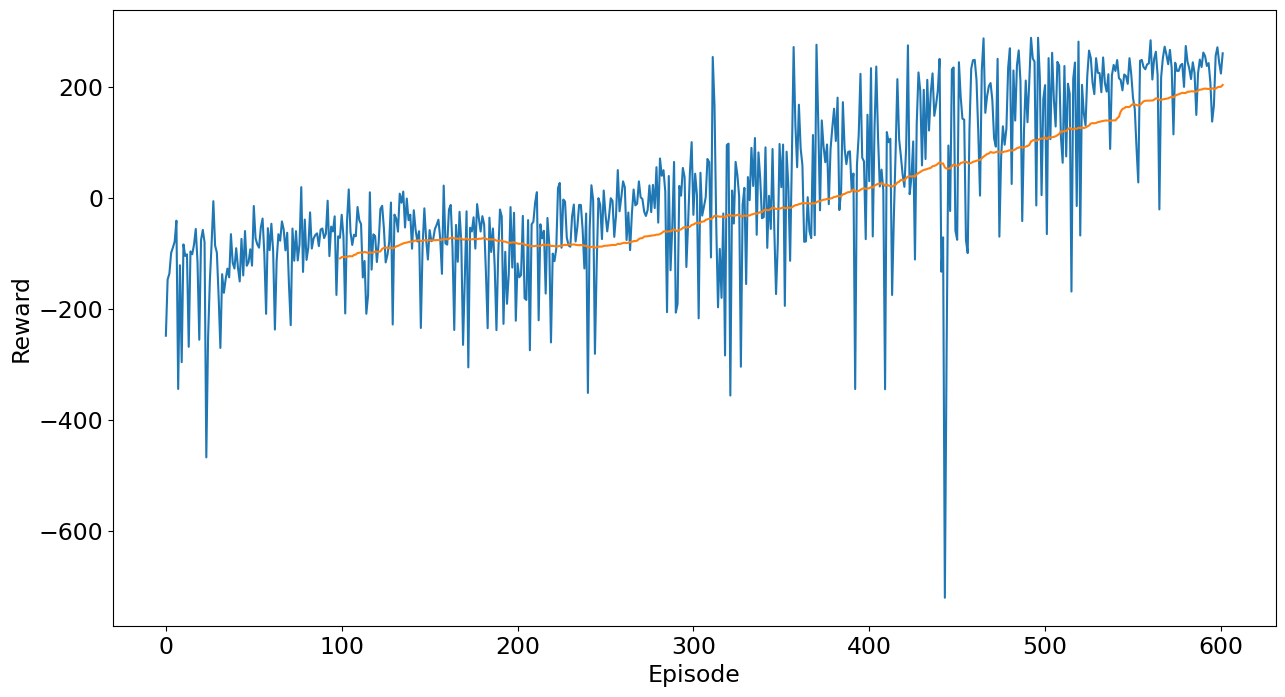

In [6]:
model.train(training_episodes, True)

# Save trained model
model.save(save_dir + "trained_model.h5")
# Save Rewards list
pickle.dump(model.rewards_list, open(save_dir + "train_rewards_list.p", "wb"))

<Figure size 640x480 with 0 Axes>

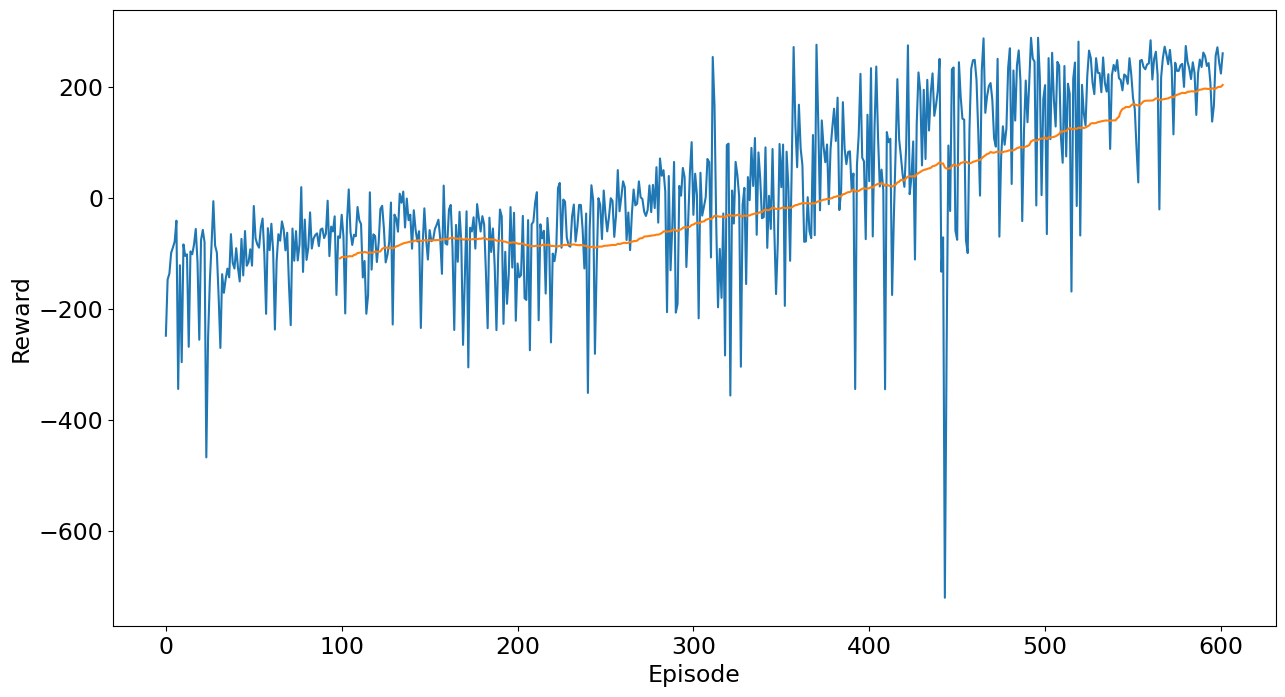

In [9]:
# plot reward in graph
rewards_list = pickle.load(open(save_dir + "train_rewards_list.p", "rb"))
reward_df = pd.DataFrame(rewards_list)
plot_df(reward_df, "Figure 1: Reward for each training episode", "Reward for each training episode", "Episode","Reward")


## Analysis

 - Looking at the graph we can see that the model manages to get an average reward of 200 (solving the environment) at around 600 episodes at which point it stops training. 
 - In general rewards seem to be climbing steadily every episode without being volatile.

Starting Testing of the trained model...
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
0 	: Episode || Reward:  254.2358140954193
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step
1 	: Episode || Reward:  241.8023087443931
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2 	: Episode || Reward:  211.4064751781729
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
3 	: Episode || Reward:  256.84879881178074
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step
4 	: Episode || Reward:  235.29077396420732
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 24ms/step
5 	: Episode || Reward:  218.45075695307796
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
6 	: Episode || Reward:  271.2112356786748
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
7 	: Episode || Reward:  249.89462376293167
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step
8 	: Episode || Reward:  269.9481435573108
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step
9 	: Episode || Reward:  236.78733721956797
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
10 	: Episode || Reward:  253.29401258142624
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step
11 	: Episode || Reward:  253.0729910107449
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
12 	: Episode || Reward:  202.17908448345392
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
13 	: Episode || Reward:  223.92488723677036
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
14 	: Episode || Reward:  261.7919425907184
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step
15 	: Episode || Reward:  91.96259159562551
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
16 	: Episode || Reward:  255.01159004608866
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
17 	: Episode || Reward:  217.1805896709302
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step
18 	: Episode || Reward:  233.9786031888392
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
19 	: Episode || Reward:  245.16461656527878
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
20 	: Episode || Reward:  198.0140839675172
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 24ms/step
21 	: Episode || Reward:  221.36921541806296
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
22 	: Episode || Reward:  233.02527705679256
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
23 	: Episode || Reward:  229.964431172614
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step
24 	: Episode || Reward:  214.36406560521266
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step
25 	: Episode || Reward:  271.48703911993243
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
26 	: Episode || Reward:  237.81231812578704
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
27 	: Episode || Reward:  224.29455942379252
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
28 	: Episode || Reward:  248.0679750687536
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
29 	: Episode || Reward:  253.8035366254006
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step
30 	: Episode || Reward:  273.19725530870346
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
31 	: Episode || Reward:  216.15977274807028
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
32 	: Episode || Reward:  177.35751385953236
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
33 	: Episode || Reward:  224.8324269082014
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
34 	: Episode || Reward:  226.36968543381965
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step
35 	: Episode || Reward:  260.522497204964
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
36 	: Episode || Reward:  168.25567138921753
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
37 	: Episode || Reward:  -36.322853740984485
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step
38 	: Episode || Reward:  273.53462375891087
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
39 	: Episode || Reward:  220.63012892334189
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
40 	: Episode || Reward:  164.7281013658524
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 18ms/step
41 	: Episode || Reward:  214.64780915591467
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
42 	: Episode || Reward:  237.32108318062316
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
43 	: Episode || Reward:  210.9840134069894
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 24ms/step
44 	: Episode || Reward:  206.88622156227171
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step
45 	: Episode || Reward:  236.67835057389368
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
46 	: Episode || Reward:  234.43439400129174
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
47 	: Episode || Reward:  244.79632515943
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
48 	: Episode || Reward:  242.93016058561477
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step
49 	: Episode || Reward:  253.37249422032318
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step
50 	: Episode || Reward:  -246.79641174020358
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
51 	: Episode || Reward:  234.84450849645754
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
52 	: Episode || Reward:  239.19739721891574
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 17ms/step
53 	: Episode || Reward:  226.52726796741155
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step
54 	: Episode || Reward:  -157.28358985022294
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step
55 	: Episode || Reward:  274.3017281357486
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
56 	: Episode || Reward:  268.9104922443102
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step
57 	: Episode || Reward:  247.0305261825556
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step
58 	: Episode || Reward:  236.53547691983732
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
59 	: Episode || Reward:  268.02813284765864
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step
60 	: Episode || Reward:  212.9525358336255
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
61 	: Episode || Reward:  242.4536828119786
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step
62 	: Episode || Reward:  240.5318472343436
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
63 	: Episode || Reward:  234.4481565829658
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
64 	: Episode || Reward:  239.94212966756842
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step
65 	: Episode || Reward:  254.03094623985797
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
66 	: Episode || Reward:  202.35282155524231
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step
67 	: Episode || Reward:  252.58993458821124
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step
68 	: Episode || Reward:  234.69400046148473
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
69 	: Episode || Reward:  227.64982459904203
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
70 	: Episode || Reward:  264.3362946104255
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
71 	: Episode || Reward:  235.3521231898131
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step
72 	: Episode || Reward:  267.00552307963426
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
73 	: Episode || Reward:  243.1523199505683
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
74 	: Episode || Reward:  249.9253168241943
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
75 	: Episode || Reward:  260.46807860373946
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
76 	: Episode || Reward:  248.68251590802407
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
77 	: Episode || Reward:  242.11044393998176
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
78 	: Episode || Reward:  232.61204160148247
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
79 	: Episode || Reward:  187.418624037581
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
80 	: Episode || Reward:  228.81004766039055
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step
81 	: Episode || Reward:  192.13358762228788
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step
82 	: Episode || Reward:  272.771519851422
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 21ms/step
83 	: Episode || Reward:  277.13626430877036
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
84 	: Episode || Reward:  253.37210404095464
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step
85 	: Episode || Reward:  257.65942639789625
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
86 	: Episode || Reward:  221.44796753457058
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
87 	: Episode || Reward:  212.9439583346536
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
88 	: Episode || Reward:  229.08741828094625
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 17ms/step
89 	: Episode || Reward:  232.68409506584976


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
90 	: Episode || Reward:  245.37053434634632
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
91 	: Episode || Reward:  235.1150490452304
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
92 	: Episode || Reward:  247.73473276560412
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step
93 	: Episode || Reward:  267.2296795993936
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
94 	: Episode || Reward:  249.72519396069143
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
95 	: Episode || Reward:  242.96272850252365
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step
96 	: Episode || Reward:  256.31585257850537
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 16ms/step
97 	: Episode || Reward:  241.9997471900894
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
98 	: Episode || Reward:  224.27646934958793
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
99 	: Episode || Reward:  247.01928951200037
Training and Testing Completed...!


<Figure size 640x480 with 0 Axes>

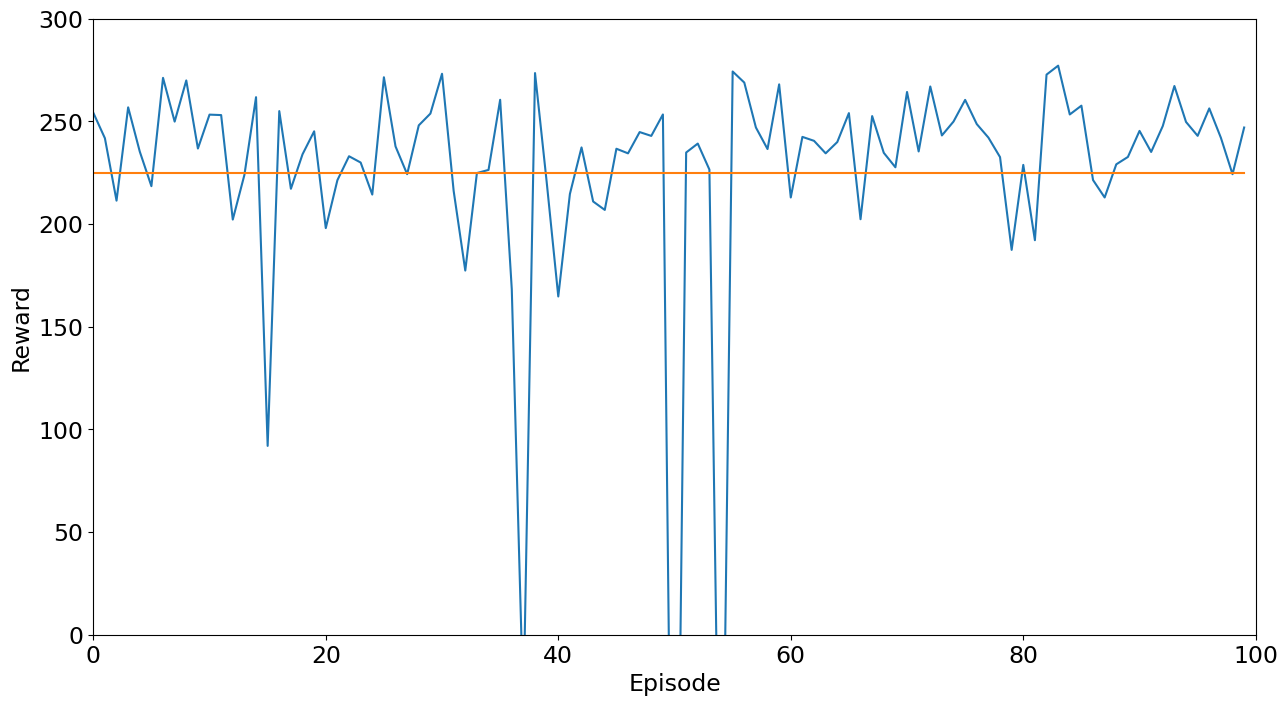

In [10]:

# Test the model
trained_model = load_model(save_dir + "trained_model.h5")
test_rewards = test_already_trained_model(trained_model)
pickle.dump(test_rewards, open(save_dir + "test_rewards.p", "wb"))
test_rewards = pickle.load(open(save_dir + "test_rewards.p", "rb"))

plot_df2(pd.DataFrame(test_rewards), "Figure 2: Reward for each testing episode","Reward for each testing episode", "Episode", "Reward")
print("Training and Testing Completed...!")

- In the testing phase we see that the model generally manages to have a reward of 200 for each episode
- Some episodes with reward lower than 200 still exist so perhaps the model can benefit from more training.